## 算式识别
- 总体概论


## 步骤0
### 导入数据集

label:
['(0+0)+9=9' '9*8+6=78' '1+7+0=8' '5+4+9=18' '7-(1*7)=0']
name of images:
['train/0.jpg' 'train/1.jpg' 'train/2.jpg' 'train/3.jpg' 'train/4.jpg']
数据集共有图片：100000
(64, 300, 3)


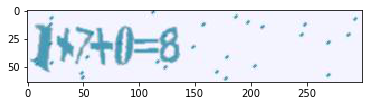

In [1]:
import pandas as pd
from sklearn.datasets import load_files 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

 # 加载标签数据
labels_file = pd.read_csv('train.csv')
label = np.array(labels_file['label'])
file_names = np.array(labels_file['filename'])

# 显示数据结构
print('label:')
print(label[:5])
print('name of images:')
print(file_names[:5])
print('数据集共有图片：%d' % len(file_names))

# 展示图片sample
img = Image.open('train/2.jpg')
print(np.array(img).shape)
plt.imshow(img)
plt.show()

In [2]:
from tqdm import tqdm

# 用PIL进行图片加载，并转换为灰度格式 
def covert_store_gray_img(img_path, store_path):
    '''read images to destination, covert to gray'''
    img = Image.open(img_path).convert('L')
    img.save(store_path)
    return img

# img = covert_store_gray_img('train/0.jpg', '0000.jpg')
# print(np.array(img))

# 设置转换灰度图片的地址到‘covert/’
destination_path = ['covert' + file_name[5:] for file_name in file_names]

# 将所有图片转化层灰度图片到目标文件夹
# all_images = [covert_store_gray_img(file_names[i], destination_path[i]) for i in range(len(file_names))]

# 将图片转化为数组
def img_to_array(img_path):
    img = Image.open(img_path)
    return np.expand_dims(np.array(img.getdata()).reshape(64, 300).astype('float32') / 255, axis=2)

# 所有图片批量转化为数组
def all_to_array(img_paths):
    list_of_tensors = [img_to_array(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)









# 将所有训练数据储存在train_data中
# train_data = all_to_array(destination_path)

In [3]:
img_to_array('covert/0.jpg')

array([[[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       ..., 
       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]],

       [[ 0.96862745],
        [ 0.96862745],
        [ 0.96862745],
        ..., 
        [ 0.96862745],
        [ 0.96862745],
        [ 0.96862745]]], dtype=float32)

## 步骤2

## 构建模型

In [4]:
# 用课堂方法构建模型
from keras.engine.topology import Input
from keras.models import *
from keras.layers import *

sequence = ['+-*()1234567890']

# 构架CNN
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(64, 300, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru1'))
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru1b'))
model.merge([gru1, gru1b], mode='sum')
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru2'))
model.add(GRU(128, return_sequences=True, init='he_normal', name='gru2b'))
model.merge(gru2, gru2b, mode='concat')
model.add(Dropout(.2))
model.summary()

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:24: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, name="gru1", return_sequences=True, kernel_initializer="he_normal")`


ValueError: Input 0 is incompatible with layer gru1: expected ndim=3, found ndim=4

In [1]:
# 用论文方法构建模型

from keras.engine.topology import Input
from keras.models import *
from keras.layers import *

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :] 测试感觉没影响
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

input_tensor = Input(shape=(64, 300, 1))
# 
x = input_tensor

x = Conv2D(filters=32, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
# x = Conv2D(filters=256, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=512, kernel_size=2, strides=2, padding='same', activation='relu')(x)

x = BatchNormalization()(x)
x = Conv2D(filters=512, kernel_size=2, strides=2, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(1, 2))(x)
x = Conv2D(filters=512, kernel_size=2, strides=2, padding='same', activation='relu')(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)
# 连接CNN和RNN的层
x = Dense(15, activation='relu')(x)
# print(x.shape)
gru_1 = GRU(128, return_sequences=True, name='gru_1')(x)
gru_1b = GRU(128, return_sequences=True, go_backwards=True, name='gru_1b')(x)

gru_1_merged = Add()([gru_1, gru_1b])


gru_2 = GRU(128, return_sequences=True, name='gru_2')(gru_1_merged)
gru_2b = GRU(128, return_sequences=True, go_backwards=True, name='gru_2b')(gru_1_merged)

x = Concatenate()([gru_2, gru_2b])

x = Dropout(.2)(x)
x = Dense(15, activation='softmax')(x)

# model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[15], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')
model.summary()
# print(x.shape)
# x.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 300, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 150, 64)  320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 75, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 38, 128)   32896       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [2]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

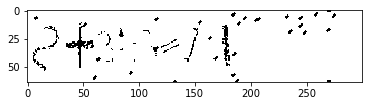

1
2
3
4
5
6
1
2
3
4
5
6
1
2
3
4
5
6
1
2
3
1
2
3
1
2
3
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
8
9
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
11
12
13
1
2
3
4
5
6
7
8
9
10
11
12
13
14
1
2
3
4

TypeError: binary_img() missing 1 required positional argument: 'threshold'

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
np.set_printoptions(threshold=np.inf) 

img = Image.open('covert/1589.jpg')
img_data = np.array(img)

# 二值化
def binary_img(img_data, threshold, pattern='plt'):
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            if img_data[i][j] > threshold:
                img_data[i][j] = 255
            else:
                img_data[i][j] = 0
    img = Image.fromarray(img_data)
    if pattern == 'plt':
        plt.imshow(img, cmap='gray')
        plt.show()
    elif pattern == 'PIL':
        img.show()
    return img_data
            
# binary_img(180)
# binary_img(220)
# binary_img(220,'PIL')

# 清楚噪点
def clear_noise(img_data):
    counter = 0
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            if img_data[i][j] == 0:
#                 print('--')
                for k in [-2,-1, 0, 1, 2]:
                    for m in [-2,-1, 0, 1, 2]:
                        if (i+k) < (img_data.shape[0]) & (j+m) < (img_data.shape[1]):
                            if img_data[i+k][j+m] == 0:
                                
                                counter += 1
                                print(counter)
                if counter < 2:
                    img_data[i][j] = 255
                    counter = 0
                counter = 0
    return img_data

# plt.imshow(img, cmap='gray')
# plt.show()
clear_noise_img = clear_noise(binary_img(img_data, 180))
Image.fromarray(clear_noise_img).show()
Image.fromarray(binary_img(200)).show()
# import cv2
# img = binary_img(180, 'PIL')
# h, w = img.shape[:2]
# blured = cv2.blur(img,(5,5)) 
# # print(blured)
# mask = np.zeros((h+2, w+2), np.uint8)
# cv2.floodFill(blured, mask, (w-1,h-1), (255,255,255), (2,2,2),(3,3,3),8)
# cv2.imshow("floodfill", blured)

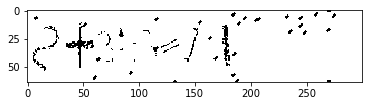

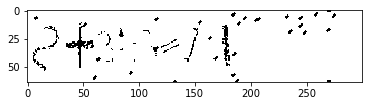

In [3]:
import cv2  
  
img = cv2.imread('train/69.jpg')  
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  
ret, binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)  
  
a ,contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
cv2.drawContours(img,contours,-1,(0,0,255),3)  
  
cv2.imshow("img", img)  
cv2.waitKey(0) 
cv2.imshow("binary", binary)  
a,contours, hierarchy = cv2.findContours(binary,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)  
cv2.imshow("binary2", binary) 
cv2.waitKey(0) 

-1

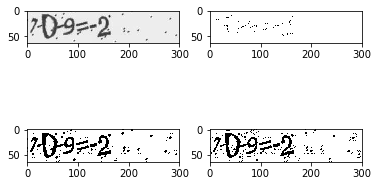

In [12]:
import cv2  
import matplotlib.pyplot as plt  
  
img = cv2.imread('covert/999.jpg',0) #直接读为灰度图像  
ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)  
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2) #换行符号 \  
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2) #换行符号 \  
images = [img,th1,th2,th3]  
plt.figure()  
for i in range(4):  
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')  
plt.show() 

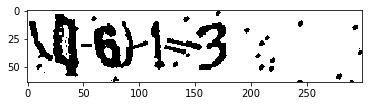

In [50]:
# 自适应二值化
# 模型最后采用该算法
import numpy as np 

import cv2  
from PIL import Image
import matplotlib.pyplot as plt  
img = cv2.imread('covert/96.jpg',0)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,17,6)
plt.imshow(th2, cmap='gray')
plt.show()
# Image.fromarray(th2).show()
# Image.fromarray(img).show()

# saltImage=saltpepper(th2,0.001)
# plt.imshow(saltImage, cmap='gray')
# plt.show()

原始灰度图


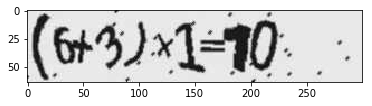

二值化图片


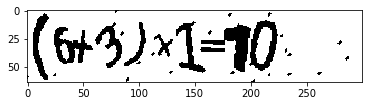

去噪图
用时：2.654483 s


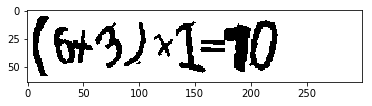

NameError: name 'imshow_PIL' is not defined

In [5]:
import time

def imshow_ply(img):
    plt.imshow(img, cmap='gray')
    plt.show()

# 二值化
def binary_img(img_data, threshold, pattern='plt'):
    for i in range(img_data.shape[0]):
        for j in range(img_data.shape[1]):
            if img_data[i][j] > threshold:
                img_data[i][j] = 255
            else:
                img_data[i][j] = 0
    img = Image.fromarray(img_data)
    if pattern == 'plt':
        plt.imshow(img, cmap='gray')
        plt.show()
    elif pattern == 'PIL':
        img.show()
    elif pattern == 'off':
        pass
    return img_data

def open_binary_img(path):
    img = Image.open(path)
    img_data_origin = np.array(img)
    img_data = binary_img(img_data_origin, 190, pattern='off')
    return img_data


img = Image.open('covert/741.jpg')
print('原始灰度图')
plt.imshow(img, cmap='gray')
plt.show()
img_data_origin = np.array(img)
img_data = binary_img(img_data_origin, 190, pattern='off')
print('二值化图片')
plt.imshow(img_data, cmap='gray')
plt.show()

def clear_noise_rect(img_data, size_window=5):
    time0 = time.time()
    counter = 0
    flag = 0
    
    # 消除上下边界的噪点
    for p in range(img_data.shape[1]):
        for h in [-2, -1, 0, 1, 2]:
            for q in range(5):
                if img_data[q][p] == 0:
                        img_data[q][p+h] = 255
            for u in [-4,-3,-2,-1, 0]:
                if img_data[63+u][p] == 0:

                        img_data[63+u][p+h] = 255
                        
    # 消除左右边界的噪点
    for w in range(img_data.shape[0]):
        for v in [-2, -1, 0, 1, 2]:
            for n in range(5):
                if img_data[w][n] == 0:
                        img_data[w+v][n] = 255
            for u in [-4,-3,-2,-1, 0]:
                if img_data[w][299+u] == 0:

                        img_data[w+v][299+u] = 255
                        
    # 用矩形框消除中间的噪点
    for i in range(img_data.shape[0] - size_window):
        for j in range(img_data.shape[1] - size_window):
            for m in range(1,size_window):
                if img_data[i][j+m] == 255:
                    counter += 1
                if img_data[i+size_window][j+m] == 255:
                    counter += 1
                if img_data[i+m][j] == 255:
                    counter += 1
                if img_data[i+m][j+size_window] == 255:
                    counter += 1
                for k in range(1, size_window):
                    if img_data[i+m][j+k] == 0:
                        flag = 1
            if img_data[i][j] == 255:
                counter += 1
            if img_data[i+size_window][j] == 255:
                counter += 1
            if img_data[i][j+size_window] == 255:
                counter += 1
            if img_data[i+size_window][j+size_window] == 255:
                counter += 1
            if flag == 1 and counter > 19:
                for t in range(size_window+1):
                    for g in range(size_window+1):
                        img_data[i+t][j+g] = 255
                        counter = 0
                        flag = 0
            counter = 0
            flag = 0
    print('用时：%f s'% (time.time()-time0))
    return img_data

print('去噪图')
clear_noise_img = clear_noise_rect(img_data, size_window=5)
# Image.fromarray(clear_noise_img).show()
imshow_ply(clear_noise_img)
imshow_PIL(clear_noise_img)

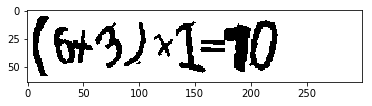

6


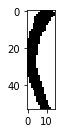

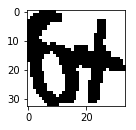

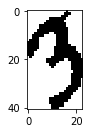

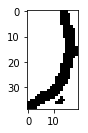

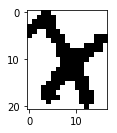

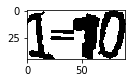

In [6]:
def getCropImages(image):
    width, height = image.size # 获取宽和高

    ## 先将字符竖着切开 去掉左右的冗余白边
    child_img_list_temp = []
    left = -1# 每个字符左边的坐标
    is_bk = False# 是否break跳出循环
    # 从最左边一列开始一列一列遍历
    for x_column in range(width):
        # 对每一列，遍历每一行
        for y_row in range(height):
            is_bk = False
            #如果一个字符的最左边还没有定位
            if left == -1 and image.getpixel((x_column, y_row)) == 0:#左边未定位 为黑色
                left = x_column
                is_bk = True
                break
            elif left != -1 and image.getpixel((x_column, y_row)) == 0:#左边已经定位 等于黑色
                is_bk = True
                break

        # 左边已经定位,且此列全为白色,并且跳出宽度小于等于6的噪声
        if not is_bk and left != -1 and x_column-left > 6:
            child_img = image.crop((left, 0, x_column, height))# 切割一次

            ## 判断是否有多个字符连接在一起
            if x_column - left > 20:
                cut_position = 0# 切割的地方
                cur_min_count = height #初始化当前最小数量的列
                is_jump = False#是否超过跳出
                # 从最左边一列开始一列一列遍历
                for i in range(child_img.width):
                    # 对每一列，遍历每一行
                    count = 0# 每列黑点数量
                    for j in range(height):
                        if child_img.getpixel((i, j)) == 0:
                            count += 1
                            # 如果当前列黑点数大于当前最小 则不符合条件 跳出
                            if count >= cur_min_count:
                                is_jump = True
                                break

                    # 如果当前列黑点数没有大于当前最小 则为最小
                    if not is_jump:
                        cur_min_count = count
                        cut_position = i

                child_img1 = child_img.crop((0, 0, cut_position, height))  # 切割一次
                child_img2 = child_img.crop((cut_position+1, 0, child_img.width, height))  # 再切割一次
                #添加重复切割后的截图
                child_img_list_temp.append(child_img1)
                child_img_list_temp.append(child_img2)
            else:
                child_img_list_temp.append(child_img)  # 切割后的图像添加到list

            left = -1
            is_bk = False

    ## 去掉每个字符上下的冗余空白
    child_img_list = []
    for child_image in child_img_list_temp:
        top = -1  # 每个字符上面的坐标
        is_bk = False  # 是否break跳出循环
        for y_row in range(height):
            # 对每一行 遍历每一列
            for x_column in range(child_image.width):
                # 如果一个字符的最上边还没有定位
                if top == -1 and child_image.getpixel((x_column, y_row)) == 0:  # 上面未定位 为黑色
                    top = y_row
                    break
                if top != -1 and child_image.getpixel((x_column, height-1-y_row)) == 0:  # 上面已经定位 等于黑色
                    is_bk = True
                    break

            # 上面已经定位,且此行全为白色
            if top != -1 and is_bk:
                # child_image.show()
                child_img = child_image.crop((0, top, child_image.width, height-y_row)) # 再次切割
                # child_img.show()
                # child_img = afterCrop(child_img)
                # child_img.show()
                if child_img:
                    child_img_list.append(child_img) # 保存到list

                break

    return child_img_list # 返回切割后的子图

imshow_ply(clear_noise_img)
images = getCropImages(Image.fromarray(clear_noise_img))
print(len(images))
for i in range(len(images)):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    
    plt.show()
# imshow_ply(images[4])
# print(images)

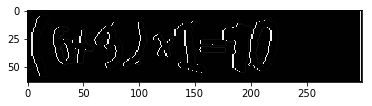

In [7]:
import cv2
import os
image, contours, hierarchy = cv2.findContours(clear_noise_img,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
imshow_ply(image)
def imshow_PIL(image):
    Image.fromarray(image).show()
    
imshow_PIL(image)
# for i in range(0,len(contours)): 
#   x, y, w, h = cv2.boundingRect(contours[i])  
#   cv2.rectangle(image, (x,y), (x+w,y+h), (153,153,0), 5)
# newimage=image[y+2:y+h-2,x+2:x+w-2] # 先用y确定高，再用x确定宽
# nrootdir=("E:/cut_image/")
# if not os.path.isdir(nrootdir):
#     os.makedirs(nrootdir)
#     cv2.imwrite( nrootdir+str(i)+".jpg",newimage) 
#     print(i)

In [8]:
# 打开一个去噪后的图片，为分割做准备
def open_clean_img(path):
    img = Image.open(path)
    img_data_origin = np.array(img)
    img_data = binary_img(img_data_origin, 190, pattern='off')
    img = clear_noise_rect(img_data)
    return img
# 用水平投影的方法分割图片
path = 'covert/1100.jpg'
imshow_PIL(np.array(Image.open(path)))
img = open_clean_img(path)
imshow_PIL(img)
# print(img.shape)

用时：2.145217 s


用时：2.087606 s
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

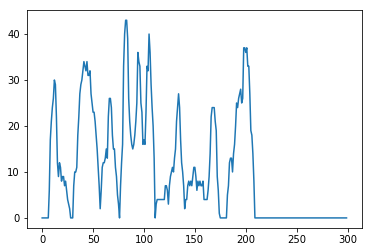

In [16]:
# 打开一个去噪后的图片，为分割做准备
def open_clean_img(path):
    img = Image.open(path)
    img_data_origin = np.array(img)
    img_data = binary_img(img_data_origin, 190, pattern='off')
    img = clear_noise_rect(img_data)
    return img
# 用水平投影的方法分割图片
path = 'covert/1122.jpg'
imshow_PIL(np.array(Image.open(path)))
img = open_clean_img(path)
imshow_PIL(img)


# 用水平投影法对图片进行分割
from collections import defaultdict
counter = defaultdict(lambda: 0)
for u in range(300):
    counter[u] = 0
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        if img[j][i] == 0:
            counter[i] += 1
# print(counter)

x = [i for i in counter.keys()]
y = [i for i in counter.values()]
print(x)
print(y)
plt.plot(x, y)
plt.show()

[[297  62]
 [  1  62]
 [  1   1]
 [297   1]]


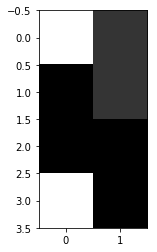

In [35]:
def findcnts_and_box_point(closed):
    # 这里opencv3返回的是三个参数
    (_, cnts, _) = cv2.findContours(closed.copy(), 
        cv2.RETR_LIST, 
        cv2.CHAIN_APPROX_SIMPLE)
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    box = np.int0(cv2.boxPoints(rect))

    return box
a = findcnts_and_box_point(img)
print(a)
plt.imshow(a, cmap='gray')
plt.show()

def drawcnts_and_cut(original_img, box):
    # 因为这个函数有极强的破坏性，所有需要在img.copy()上画
    # draw a bounding box arounded the detected barcode and display the image
    draw_img = cv2.drawContours(original_img.copy(), [box], -1, (0, 0, 255), 3)

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)
    hight = y2 - y1
    width = x2 - x1
    crop_img = original_img[y1:y1+hight, x1:x1+width]

    return draw_img, crop_img
drawcnts_and_cut(findcnts_and_box_point)

In [32]:
from keras.models import *
from keras.layers import *
rnn_size = 128


from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(64, 300, 3))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img).transpose(1, 0, 2)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
# print(path_to_tensor('train/0.jpg').shape)


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :] 测试感觉没影响
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
character = '0123456789-+*=()'
mini_batch = []
n_len = []
batch_file_names = []
input_tensor = []
y_train = []
for i in range(10):
#     str = 
#     print(type(file_names[i]))
#     for x in label[i]:
#         print(x)
    a = [character.find(x) for x in label[i]]
    y_train.append(a)
    
    n_len.append(len(label[i]))
    batch_file_names.append(file_names[i])
# print(batch_file_names)
# print(n_len)
print(np.array(y_train).shape)
tensor = paths_to_tensor(batch_file_names)
# print(tensor.shape)


width, height, n_class = 300, 64, 15
input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Convolution2D(32, (3, 3), activation='relu')(x)
    x = Convolution2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged = add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
x = concatenate([gru_2, gru_2b])
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[8], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])
print({'ctc': lambda y_true, y_pred: y_pred})
model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')
print(model)
model.summary()

# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

(10,)


100%|█████████████████████████████████████████| 10/10 [00:00<00:00, 714.25it/s]
C:\ProgramData\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:77: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


{'ctc': <function <lambda> at 0x000000000FE5FF28>}
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 300, 64, 3)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 298, 62, 32)  896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 296, 60, 32)  9248        conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 148, 30, 32)  0           conv2d_26[0][0]                  
__________________________________________________________

In [4]:
# 小批量测试
from keras import backend as K
y_pred = base_model.predict(tensor)
print(y_pred.shape)
print(mini_batch[1])
shape = y_pred[:,:,:].shape
print(shape)
print(K.get_value(K.ctc_decode(y_pred[:,:,:], input_length=np.ones(shape[0])*shape[1])[0][0]).shape)


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :] 测试感觉没影响
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print( y_pred[3].shape)
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1])[0][0])
print(out)
# print(a.shape)
def evaluate(model, batch_num=10):
    batch_acc = 0
#     generator = gen(128)
    for i in range(batch_num):
        
        y_pred = base_model.predict(tensor)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
        
        batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
#         print
        print ('acc: %f%%'%acc)

evaluator = Evaluate()

# model.fit([tensor,mini_batch, 13,n_len],callbacks=[EarlyStopping(patience=10), evaluator])


(10, 34, 15)
9*8+6=78
(10, 34, 15)
(10, 16)
(34, 15)
[[ 9  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 9 12  2 12  2 12  2 12  2 -1 -1 -1 -1 -1 -1 -1]
 [ 1  9 12  2 12  2 12  9  2  1 12  2  1  2  1  2]
 [ 9 12  2 12  2 12  2 12  2  1  2 -1 -1 -1 -1 -1]
 [ 9  1 12  1  2  9  1  2  1 12  2  1  2 -1 -1 -1]
 [ 9  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [10  9 12  2 12  2 12  2 12  2 -1 -1 -1 -1 -1 -1]
 [ 1 12  1  9  1  2  1  2  1  2 12  2 -1 -1 -1 -1]
 [ 7 12  2 12  2 12  2 12  2 12  2 -1 -1 -1 -1 -1]
 [11  2 12  2 12  2 12  9  2 12  2 12  2 -1 -1 -1]]


In [12]:
characters=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
y_pred = base_model.predict(tensor)
# y_pred = y_pred[:,2:,:]
batch_acc=0
for i in range(10):
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
    print(out.shape)
    print(mini_batch)
    batch_acc += ((mini_batch == out).sum(axis=1) == 4).mean()
    # out = ''.join([characters[x] for x in out[1]])
#     print(out)


(10, 16)
['(0+0)+9=9', '9*8+6=78', '1+7+0=8', '5+4+9=18', '7-(1*7)=0', '4-1+0=3', '(0*7)+0=0', '(2*8)*8=128', '(4+9)*4=52', '3+8+8=19']


C:\ProgramData\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


AttributeError: 'bool' object has no attribute 'sum'

In [16]:
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen(128)
    for i in range(batch_num):
        X_test = tensor
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
        
        batch_acc += ((mini_batch == out).sum(axis=1)).mean()
    return batch_acc / batch_num

from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
#         print
        print ('acc: %f%%'%acc)
def input_tesor(tensor, mini_batch, base_model, n_len):
    for i in range(10):
        X_test = tensor
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])
    return [tensor, mini_batch, np.ones(shape[0])*shape[1], n_len]
evaluator = Evaluate()

model.fit(input_tesor(tensor, mini_batch, base_model, n_len), batch_size=10, steps_per_epoch=1, nb_epoch=15,
                    callbacks=[EarlyStopping(patience=10), evaluator],
         validation_data=input_tesor(tensor, mini_batch, base_model, n_len), validation_steps=1)

C:\ProgramData\Anaconda3\envs\dog-project\lib\site-packages\ipykernel\__main__.py:35: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


AttributeError: 'list' object has no attribute 'ndim'